# Bootstrap example

1. Bootstrap the entire dataset
2. Parse ranking by accordance
3. Parse ranking by seasonality

In [130]:
import pandas as pd
import sys
import random
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import numpy as np
from NcReader import *
from Experiment import *
from Stats import *

In [131]:
e = Experiment('/home/hma000/accomatic-web/tests/test_data/toml/SEP_KDI.toml')

df = e.mod().join(e.obs()).dropna()
df = df.groupby(['time']).mean()
df['ens'] = df[['era5','merr','jra5']].mean(axis=1)
models = ['ens','era5','merr','jra5']

/home/hma000/.conda/envs/acco/lib/python3.9/site-packages/pandas/core/indexes/base.py:327: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return libjoin.left_join_indexer_unique(sv, ov)


# Plotting timeseries visualization of data

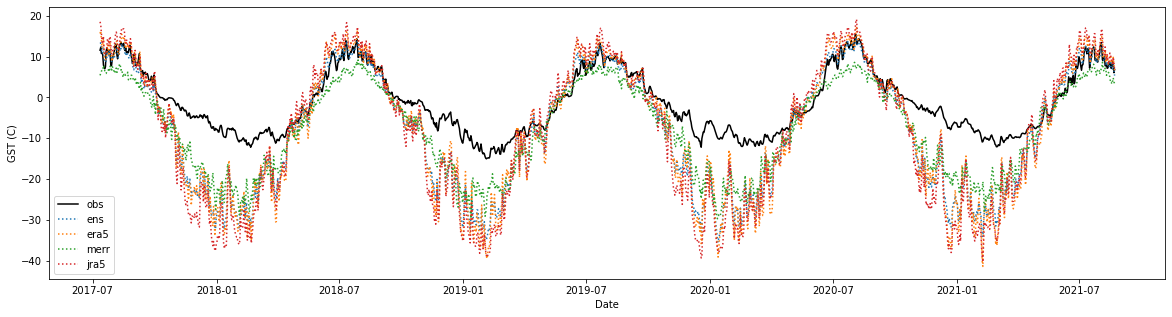

In [132]:
fig, ax = plt.subplots(figsize=(20, 5))

plt.plot(df.index, df['obs'], 'k', label='obs')
for mod in models:
    plt.plot(df.index, df[mod], ':', label=mod)

# Set title and labels for axes
ax.set(xlabel="Date", ylabel="GST (C)")
ax.legend()
plt.show()

# Setting up bootstrap experiment

In [133]:

def boot(df, boot_size=1000, consecutive_days_slice=5):
    b_rmse, b_bias, b_r2 = [], [], []
    nrows = range(df.shape[0])

    for i in range(boot_size):
        # Select 5 consecutive days 
        ix = random.randint(nrows.start, nrows.stop-consecutive_days_slice)
        a = df.iloc[ix:ix+consecutive_days_slice, :]
        b_rmse.append(mean_squared_error(a['obs'], a['era5'], squared=False))
        b_bias.append((a['era5'] - a['obs']).sum()/consecutive_days_slice)
        b_r2.append(r2_score(a['obs'], a['era5']))
    
    return [np.array(b_rmse), np.array(b_bias), np.array(b_r2)]

b_res = boot(df) #(3, 1000)
for i in range(len(b_res)):
    b_res[i] = sorted(b_res[i])
    b_res[i] = b_res[i][25:995]
    




970


Text(0.5, 1.0, 'R2')

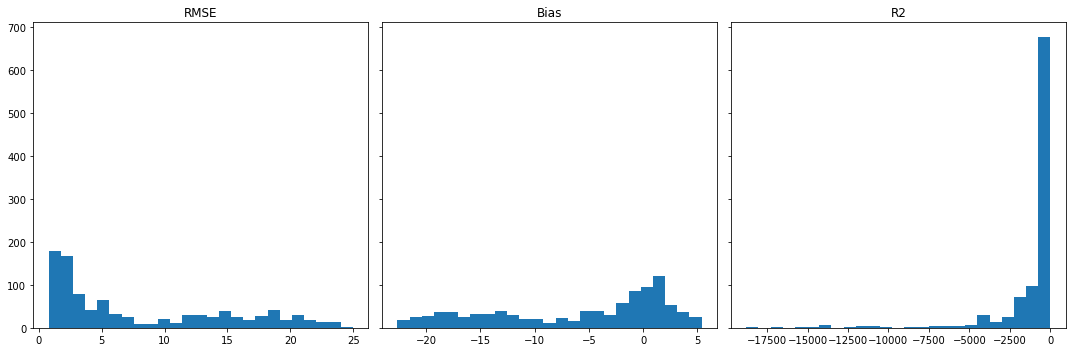

In [134]:
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(15, 5))
# We can set the number of bins with the *bins* keyword argument.
n_bins = 25
axs[0].hist(b_res[0], bins=n_bins)
axs[0].set_title('RMSE')
axs[1].hist(b_res[1], bins=n_bins)
axs[1].set_title('Bias')
axs[2].hist(b_res[2], bins=n_bins)
axs[2].set_title('R2')


# Plotting histogram of bootstrap results

Text(0.5, 1.0, 'Bias')

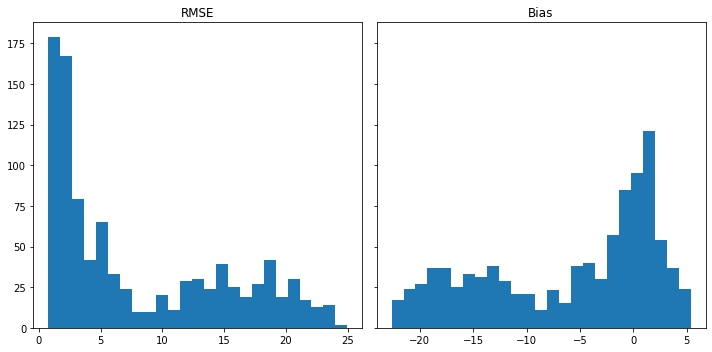

In [135]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize=(10,5))

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(b_res[0], bins=n_bins)
axs[0].set_title('RMSE')
axs[1].hist(b_res[1], bins=n_bins)
axs[1].set_title('Bias')

# Box and whisker plot of performance

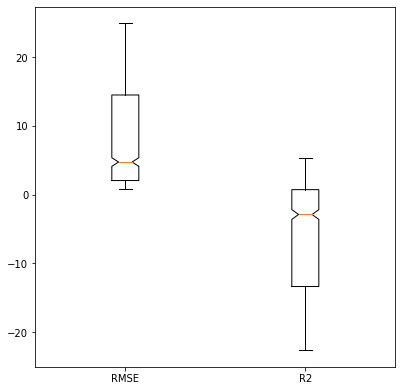

In [136]:
data = [b_res[0], b_res[1]]
fig = plt.figure(figsize =(5, 5))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data, notch=True)
ax.set_xticklabels(['RMSE', 'R2'])
plt.show()

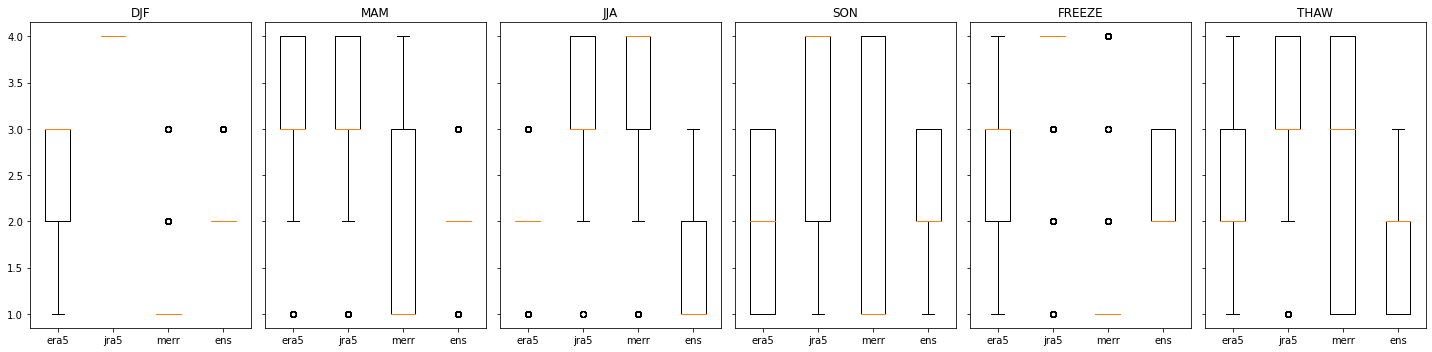

In [168]:

    
def boot(szn_df, boot_size=1000, consecutive_days_slice=10):

    nrows = range(szn_df.shape[0])
    sims = szn_df.drop(columns='obs').columns
    old_results = []
    
    # Do a bajillion times per season experiment
    for i in range(boot_size):
        # Select t consecutive days 
        ix = random.randint(nrows.start, nrows.stop-consecutive_days_slice)
        a = szn_df.iloc[ix:ix+consecutive_days_slice, :]
        row = [] 
        for sim in (sims):
            row.append(stats['RMSE'](a.obs, a[sim]))
            # row = [ VAL, VAL, VAL, VAL ]
        old_results.append(row)
        # old_results = [ [ VAL, VAL, VAL, VAL ], [ VAL, VAL, VAL, VAL ], ... ]

    old_results = pd.DataFrame(old_results, columns = sims) 
    old_results = old_results.rank(axis=1, method="max").astype(int)
    old_results = old_results.to_numpy()
            
    # (4, 1000)
    # (sim, runs)
    return old_results

time_code_months = {
    "DJF": [1, 2, 12],
    "MAM": [3, 4, 5],
    "JJA": [6, 7, 8],
    "SON": [9, 10, 11],
    "FREEZE": [10, 11, 12, 1, 2, 3],
    "THAW": [4, 5, 6, 7, 8, 9],
}

df = df.set_index(pd.to_datetime(df.index))

data = {}
for szn in time_code_months.keys():
    szn_df = df[df.index.month.isin(time_code_months[szn])]
    data[szn] = boot(szn_df)

n_plots = len(data.keys())
fig, axs = plt.subplots(1, n_plots, sharey=True, tight_layout=True, figsize=(20, 5))
for i, szn in zip(range(n_plots), data.keys()):
    axs[i].set_title(szn)
    bp = axs[i].boxplot(data[szn], whis=1.5)
    axs[i].set_xticklabels(df.drop(columns='obs').columns)

plt.show()





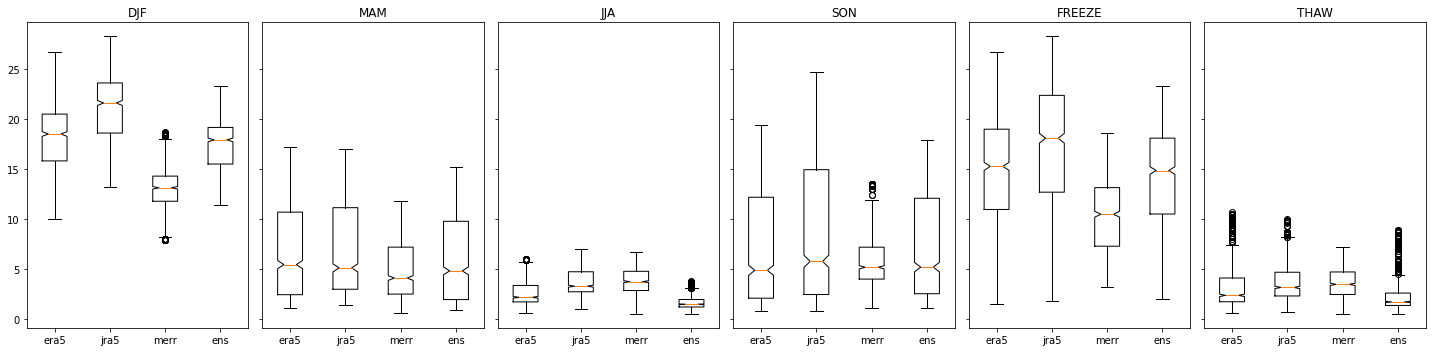

In [123]:
def boot(szn_df, sim, boot_size=1000, consecutive_days_slice=10, stat_list=[]):

    nrows = range(szn_df.shape[0])
    b_res = []

    for stat in stat_list:
        res = []
        for i in range(boot_size):
            # Select 5 consecutive days 
            ix = random.randint(nrows.start, nrows.stop-consecutive_days_slice)
            a = szn_df.iloc[ix:ix+consecutive_days_slice, :]
            res.append(stats[stat](a.obs, a[sim]))

        b_res.append(res)

    for i in b_res:
        i = np.array(i)
        i = sorted(i)
        i = i[25:975]
    
    return b_res[0]

time_code_months = {
    "DJF": [1, 2, 12],
    "MAM": [3, 4, 5],
    "JJA": [6, 7, 8],
    "SON": [9, 10, 11],
    "FREEZE": [10, 11, 12, 1, 2, 3],
    "THAW": [4, 5, 6, 7, 8, 9],
}

df = df.set_index(pd.to_datetime(df.index))

data = {}
for szn in time_code_months.keys():
    szn_df = df[df.index.month.isin(time_code_months[szn])]
    b_res = []
    for sim in szn_df.drop(columns='obs').columns:
        b_res.append(boot(szn_df, sim, stat_list=['RMSE']))
        # Sim, season = array    
    data[szn] = b_res

n_plots = len(data.keys())
fig, axs = plt.subplots(1, n_plots, sharey=True, tight_layout=True, figsize=(20, 5))
for i, szn in zip(range(n_plots), data.keys()):
    axs[i].set_title(szn)
    bp = axs[i].boxplot(data[szn], notch=True)
    axs[i].set_xticklabels(df.drop(columns='obs').columns)

plt.show()


